In [1]:
import configparser
import csv
import os
import os.path as ops
import pickle

from PIL import Image
import numpy as np
import scipy
import torch

import matplotlib.pyplot as plt
import argparse
import glob
import json
import cv2
import sys
sys.path.append("..")
from dataset.cosmos_dataset import COSMOSDatasetVehicle, COSMOSDatasetVehicle_AUG, COSMOSDatasetVehicleTtoD

In [2]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# Get Faster R-CNN

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_detection_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.nms_thresh = 0.3
    
    return model

# Define the dataset

In [4]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:
class COSMOSDatasetVehicleOandA(torch.utils.data.Dataset):
    def __init__(self, dataset_org, dataset_aug):
        self.dataset_org = dataset_org
        self.dataset_aug = dataset_aug
        self.dataset_org_len = len(dataset_org)
        self.dataset_aug_len = len(dataset_aug)
        self._classes = ('Background', 'Vehicle')
    @property
    def num_classes(self):
        return len(self._classes)
    def __getitem__(self, idx):
        if idx < self.dataset_org_len:
            return self.dataset_org[idx]
        else:
            return self.dataset_aug[idx-self.dataset_org_len]
    def __len__(self):
        return self.dataset_org_len+self.dataset_aug_len

In [6]:
dataset_path = '../../COSMOS_data_tracktor/detection_dataset/maskrcnn_lablled-bbox-train-val'
dataset_path_aug = '../../COSMOS_data_tracktor/detection_dataset/detection_dataset3'

dataset_org = COSMOSDatasetVehicle(dataset_path, get_transform(train=False))
dataset_aug = COSMOSDatasetVehicle_AUG(dataset_path_aug, get_transform(train=False))

dataset = COSMOSDatasetVehicleOandA(dataset_org, dataset_aug)

torch.manual_seed(1)
data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=2, 
                                          shuffle=True, num_workers=4, collate_fn=utils.collate_fn)

In [7]:
print(len(dataset_org))
print(len(dataset_aug))
print(len(dataset))

1506
1692
3198


# Training

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_detection_model(dataset.num_classes)

#model_path = '/home/ecbm4040/COSMOS_data/frcnn_cosmos_output/faster_rcnn_fpn_training_cosmos/model_vehicle_O&A_second_epoch_20.model'

#model.load_state_dict(torch.load(model_path))


# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [8]:
def evaluate_and_write_result_files(model, parent_set, data_loader, output_dir):
    model.eval()
    results = {}
    for imgs, targets in data_loader:
        imgs = [img.to(device) for img in imgs]
        with torch.no_grad():
            preds = model(imgs)
        for pred, target in zip(preds, targets):
            results[target['image_id'].item()] = {'boxes': pred['boxes'].cpu(),
                                                  'labels': pred['labels'].cpu(),
                                                  'scores': pred['scores'].cpu()}
    dataset_len = len(data_loader.dataset)
    parent_set.print_eval(dataset_len, results, ovthresh=0.5)
    # parent_set.print_eval(dataset_len, results, ovthresh=0.75)
    #parent_set.write_results_files(results, output_dir)          

In [9]:
output_dir = None
dataset_path_tracking = '../../COSMOS_data_tracktor/Track_data_cosmos/only_v/traffic_video_GP020614_190720_0237_0407_90sec_calibrated'
dataset_test3 = COSMOSDatasetVehicleTtoD(dataset_path_tracking, get_transform(train=False))
torch.manual_seed(1)
data_loader_test3 = torch.utils.data.DataLoader(dataset_test3, batch_size=1, 
                                                    shuffle=False, num_workers=4, collate_fn=utils.collate_fn)
evaluate_and_write_result_files(model, dataset_test3, data_loader_test3, output_dir)

In [ ]:
num_epochs = 20
output_dir = None

for epoch in range(1, num_epochs + 1):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=40)
    lr_scheduler.step()
    if epoch % 4 == 0:
        # evaluate_and_write_result_files(model, dataset, data_loader_valid, output_dir)
        evaluate_and_write_result_files(model, dataset_test3, data_loader_test3, output_dir)
        torch.save(model.state_dict(), 
                       f"../../COSMOS_data_tracktor/frcnn_cosmos_output/faster_rcnn_fpn_training_cosmos/model_vehicle_O&A_second_adam_epoch_{epoch}.model")

# Test on other dataset

In [9]:
def get_detection_model2(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.nms_thresh = 0.7
    
    return model

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# get the model using our helper function
model = get_detection_model(2)
model2 = get_detection_model(2)

# model_path = '/home/ecbm4040/COSMOS_data/frcnn_cosmos_output/faster_rcnn_fpn_training_cosmos/model_vehicle_O&A_second_epoch_20.model'
model_path = '../../COSMOS_data_tracktor/frcnn_cosmos_output/faster_rcnn_fpn_training_cosmos/model_vehicle_O&A_second_epoch_24.model'
model.load_state_dict(torch.load(model_path))
model2.load_state_dict(torch.load(model_path))
# move model to the right device
model.to(device)
model2.to(device)
print('success')

success


In [25]:
def evaluate_and_write_result_files(model, parent_set, data_loader, output_dir):
    model.eval()
    results = {}
    for imgs, targets in data_loader:
        imgs = [img.to(device) for img in imgs]
        with torch.no_grad():
            preds = model(imgs)
        for pred, target in zip(preds, targets):
            results[target['image_id'].item()] = {'boxes': pred['boxes'].cpu(),
                                                  'labels': pred['labels'].cpu(),
                                                  'scores': pred['scores'].cpu()}
    dataset_len = len(data_loader.dataset)
    parent_set.print_eval(dataset_len, results, ovthresh=0.5)
    parent_set.print_eval(dataset_len, results, ovthresh=0.75)
    #parent_set.write_results_files(results, output_dir)          

In [26]:
output_dir = None

In [15]:
dataset_path_tracking = '../../COSMOS_data_tracktor/Track_data_cosmos/only_v/mudd12a2_122200_122330_calibrated'
dataset_test3 = COSMOSDatasetVehicleTtoD(dataset_path_tracking, get_transform(train=False))
torch.manual_seed(1)
data_loader_test3 = torch.utils.data.DataLoader(dataset_test3, batch_size=1, 
                                                    shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

evaluate_and_write_result_files(model, dataset_test3, data_loader_test3, output_dir)

AP: 0.9128959752515924 Prec: 0.9368 Rec: 0.9578296828137781 TP: 10539.0 FP: 711.0
AP: 0.1373182553146099 Prec: 0.35484444444444446 Rec: 0.3628101426883577 TP: 3992.0 FP: 7258.0
AP: 0.9128959752515924 Prec: 0.9368 Rec: 0.9578296828137781 TP: 10539.0 FP: 711.0
AP: 0.1373182553146099 Prec: 0.35484444444444446 Rec: 0.3628101426883577 TP: 3992.0 FP: 7258.0


In [18]:
dataset_path_tracking = '../../COSMOS_data_tracktor/Track_data_cosmos/only_v/traffic_video_GP010615_190724_0545_0715_90sec_calibrated'
dataset_test4 = COSMOSDatasetVehicleTtoD(dataset_path_tracking, get_transform(train=False))
torch.manual_seed(1)
data_loader_test4 = torch.utils.data.DataLoader(dataset_test4, batch_size=1, 
                                                    shuffle=False, num_workers=4, collate_fn=utils.collate_fn)
evaluate_and_write_result_files(model, dataset_test4, data_loader_test4, output_dir)

AP: 0.9572249750262556 Prec: 0.9627271315421649 Rec: 0.9941198481851713 TP: 18597.0 FP: 720.0
AP: 0.7124476278088692 Prec: 0.827198840399648 Rec: 0.8541722349922489 TP: 15979.0 FP: 3338.0
AP: 0.9572249750262556 Prec: 0.9627271315421649 Rec: 0.9941198481851713 TP: 18597.0 FP: 720.0
AP: 0.7124476278088692 Prec: 0.827198840399648 Rec: 0.8541722349922489 TP: 15979.0 FP: 3338.0


In [20]:
dataset_path_tracking = '../../COSMOS_data_tracktor/Track_data_cosmos/only_v/traffic_video_GP020614_190720_0237_0407_90sec_calibrated'
dataset_test5 = COSMOSDatasetVehicleTtoD(dataset_path_tracking, get_transform(train=False))
torch.manual_seed(1)
data_loader_test5 = torch.utils.data.DataLoader(dataset_test5, batch_size=1, 
                                                    shuffle=False, num_workers=4, collate_fn=utils.collate_fn)
evaluate_and_write_result_files(model, dataset_test5, data_loader_test5, output_dir)

AP: 0.8377412633443215 Prec: 0.8340799297321037 Rec: 0.9981080512928316 TP: 9496.0 FP: 1889.0
AP: 0.41737810607538806 Prec: 0.5826086956521739 Rec: 0.6971830985915493 TP: 6633.0 FP: 4752.0


In [21]:
dataset_path_tracking = '../../COSMOS_data_tracktor/Track_data_cosmos/only_v/traffic_video_HIKL1D190821T000900_190920_0152_0322_90sec_calied'
dataset_test6 = COSMOSDatasetVehicleTtoD(dataset_path_tracking, get_transform(train=False))
torch.manual_seed(1)
data_loader_test6 = torch.utils.data.DataLoader(dataset_test6, batch_size=1, 
                                                    shuffle=False, num_workers=4, collate_fn=utils.collate_fn)
evaluate_and_write_result_files(model, dataset_test6, data_loader_test6, output_dir)

AP: 0.8909939808239244 Prec: 0.8864011312750413 Rec: 0.9981422505307855 TP: 7522.0 FP: 964.0
AP: 0.653806613450567 Prec: 0.7492340325241574 Rec: 0.8436836518046709 TP: 6358.0 FP: 2128.0


In [22]:
dataset_path_tracking = '../../COSMOS_data_tracktor/Track_data_cosmos/only_v/traffic_video_HIKL1D190821T200329_190916_1715_1845_90sec_calied'
dataset_test7 = COSMOSDatasetVehicleTtoD(dataset_path_tracking, get_transform(train=False))
torch.manual_seed(1)
data_loader_test7 = torch.utils.data.DataLoader(dataset_test7, batch_size=1, 
                                                    shuffle=False, num_workers=4, collate_fn=utils.collate_fn)
evaluate_and_write_result_files(model, dataset_test7, data_loader_test7, output_dir)

AP: 0.922665268470801 Prec: 0.9221909736172492 Rec: 0.9978264019707289 TP: 6886.0 FP: 581.0
AP: 0.41369172207582305 Prec: 0.6002410606669345 Rec: 0.6494710911462107 TP: 4482.0 FP: 2985.0


In [23]:
dataset_path_tracking = '../../COSMOS_data_tracktor/Track_data_cosmos/only_v/traffic_video_HIKL1D190821T200329_190919_2350_2520_90sec_calied'
dataset_test8 = COSMOSDatasetVehicleTtoD(dataset_path_tracking, get_transform(train=False))
torch.manual_seed(1)
data_loader_test8 = torch.utils.data.DataLoader(dataset_test8, batch_size=1, 
                                                    shuffle=False, num_workers=4, collate_fn=utils.collate_fn)
evaluate_and_write_result_files(model, dataset_test8, data_loader_test8, output_dir)

AP: 0.8367999858869186 Prec: 0.8768556826478462 Rec: 0.9460417487199685 TP: 7206.0 FP: 1012.0
AP: 0.22982112635375057 Prec: 0.44986614748113896 Rec: 0.485361690954444 TP: 3697.0 FP: 4521.0


# Show some result

In [61]:
model.eval()
num = 0
for imgs, targets in data_loader_test5:
    imgs = [img.to(device) for img in imgs]
    with torch.no_grad():
        preds = model(imgs)
        num += 1
    if num == 100:
        break

In [62]:
pred = preds[0]['boxes'].to('cpu').numpy()

In [63]:
imgs_numpy = imgs[0].to('cpu').numpy()

In [67]:
target = targets[0]['boxes'].to('cpu').numpy()

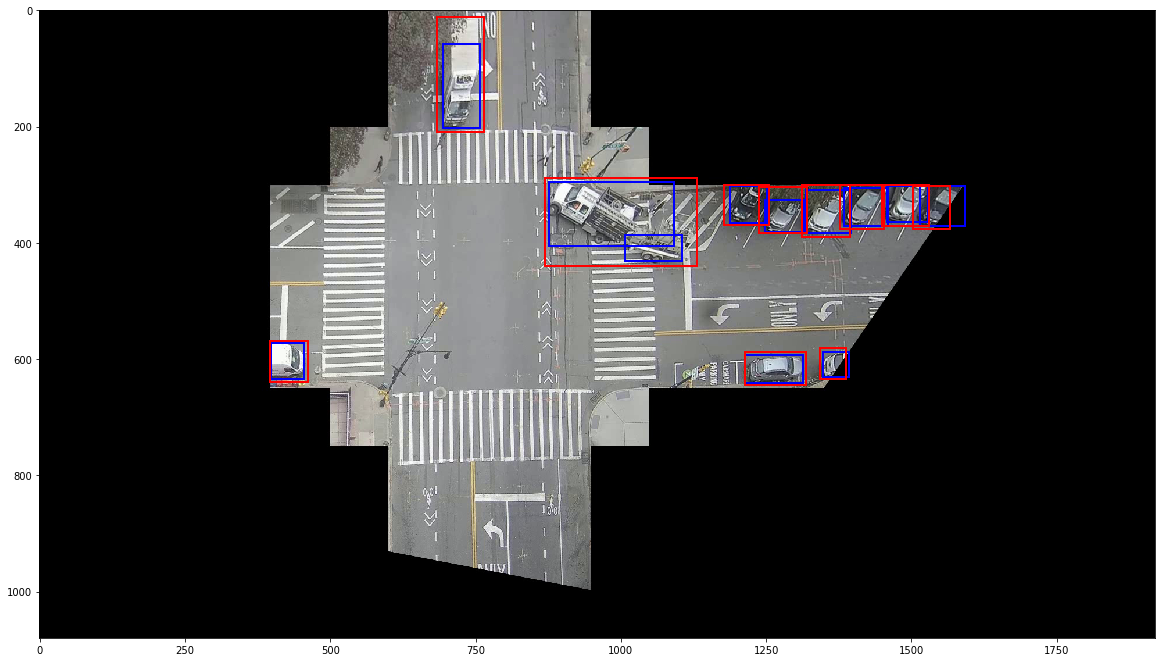

In [68]:
import matplotlib.patches as patches
plt.figure(figsize=(20,20))
plt.imshow(imgs_numpy.transpose(1,2,0))
currentAxis=plt.gca()
for box in pred:
    rect=patches.Rectangle((box[0], box[1]),
                          box[2]-box[0],box[3]-box[1],
                           linewidth=2,edgecolor='b',facecolor='none')
    currentAxis.add_patch(rect)
for label in target:
    rect=patches.Rectangle((label[0], label[1]),
                          label[2]-label[0],label[3]-label[1],
                           linewidth=2,edgecolor='r',facecolor='none')
    currentAxis.add_patch(rect)
plt.show()